In [61]:
from keras.src.engine.base_layer import Layer
from keras.src.engine.keras_tensor import KerasTensor
from keras.src.losses import mse
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
schemas = [['E1', 'p1x', 'p1y', 'p1z'], 
           ['E2', 'p2x', 'p2y', 'p2z'],
           ['E3', 'p3x', 'p3y', 'p3z'], 
           ['E4', 'p4x', 'p4y', 'p4z']]
schemas

[['E1', 'p1x', 'p1y', 'p1z'],
 ['E2', 'p2x', 'p2y', 'p2z'],
 ['E3', 'p3x', 'p3y', 'p3z'],
 ['E4', 'p4x', 'p4y', 'p4z']]

In [35]:
def inv_mass(x: Layer) -> tf.Tensor:
    e_tensor = tf.gather(x, [0, 4, 8, 12], axis=1)
    x_tensor = tf.gather(x, [1, 5, 9, 13], axis=1)
    y_tensor = tf.gather(x, [2, 6, 10, 14], axis=1)
    z_tensor = tf.gather(x, [3, 7, 11, 15], axis=1)
    return (
        tf.square(tf.reduce_sum(e_tensor, axis=1))
        - tf.square(tf.reduce_sum(x_tensor, axis=1))
        - tf.square(tf.reduce_sum(y_tensor, axis=1))
        - tf.square(tf.reduce_sum(z_tensor, axis=1))
    )

In [54]:
def vae_loss(
    x: Layer,
    x_decoded_mean: Layer,
    z_log_var: Layer,
    z_mean: Layer,
) -> KerasTensor:
    mse_loss = mse(x, x_decoded_mean)
    kl_loss = z_log_var + 1 - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    inv_m_loss = tf.square(inv_mass(x) - inv_mass(x_decoded_mean))
    beta = 10 ** (-6)
    alpha = 10 ** (-6)
    loss = K.mean((1 - beta - alpha) * mse_loss + beta * kl_loss + alpha * inv_m_loss)
    return loss

In [18]:
data = pd.read_csv('four_guys.csv', sep=" ", names=np.array(schemas).flatten())
data.head()

,E1,p1x,p1y,p1z,E2,p2x,p2y,p2z,E3,p3x,p3y,p3z,E4,p4x,p4y,p4z
0,20.274241,13.753708,1.397849,14.829915,13.459523,-13.458053,-0.178631,0.087476,10.726935,1.457106,-9.715445,-4.306151,19.941356,-1.752761,8.496227,17.955180
1,152.820099,63.584427,18.996694,-137.659427,164.917905,4.471840,31.646155,-161.791309,137.529487,-39.586901,-44.338982,-124.021291,39.559938,-28.469366,-6.303867,-26.734509
2,51.267102,27.995380,26.039697,34.154190,43.013595,-7.827488,-17.337374,-38.578689,123.210062,0.378806,-41.833551,115.890116,46.883635,-20.546697,33.131228,26.042638
3,64.805282,-3.653628,46.355274,45.139262,38.158727,-29.094263,-15.298609,-19.379208,57.805237,34.629435,10.578369,45.059234,42.993259,-1.881544,-41.635034,10.554281
4,25.501529,17.607195,-7.617831,-16.800957,22.270427,3.366801,16.786119,-14.242599,36.269401,-21.935459,13.187325,-25.698023,47.012227,0.961463,-22.355613,-41.345380


In [21]:
means = pd.read_csv('four_guys.csv.latent_mean.csv', sep=" ", names=np.array(schemas).flatten())
means.head()

,,,,E1,p1x,p1y,p1z,E2,p2x,p2y,p2z,E3,p3x,p3y,p3z,E4,p4x,p4y,p4z
-0.552200,-1.595257,3.217902,1.967519,0.598932,-1.405670,-1.082503,-0.752241,2.614413,1.092358,-6.032957,1.916500,1.443225,1.808575,-1.031013,1.016688,-0.278667,0.987186,3.808554,1.384726
-0.606270,-1.864357,3.041797,2.324298,0.482504,-1.287469,-1.204194,-0.269872,3.050050,0.644958,-6.092378,1.428873,1.524287,2.035575,-0.767109,1.392910,-0.393350,1.460187,3.977250,1.309302
-0.519415,-1.617143,2.461672,1.515917,0.463803,-1.258280,-0.949081,-0.415559,2.149951,0.987547,-4.588554,1.159920,0.948834,1.605305,-0.928079,1.254038,-0.147118,1.032950,2.959656,1.061694
-0.722961,-2.063609,2.966812,2.103067,0.717500,-1.448642,-1.323827,-0.487124,2.708782,1.171290,-5.889198,1.459677,1.249279,1.932521,-1.113596,1.514586,-0.317438,1.251599,3.834829,1.155021
-0.727132,-1.707015,3.099955,1.665745,0.449598,-1.583826,-0.951240,-0.741455,2.389848,1.207128,-5.118530,1.498605,1.595084,1.816208,-1.032870,1.076777,-0.063160,0.966358,3.626057,1.454883


In [22]:
stds = pd.read_csv('four_guys.csv.latent_std.csv', sep=" ", names=np.array(schemas).flatten())
stds.head()

,,,,E1,p1x,p1y,p1z,E2,p2x,p2y,p2z,E3,p3x,p3y,p3z,E4,p4x,p4y,p4z
0.509608,0.328267,0.612831,0.552864,0.258287,0.221938,0.344367,0.506722,0.705423,0.343847,0.281302,0.328061,0.429542,0.551178,0.429658,0.311801,0.349972,0.148201,0.201291,0.257988
0.542954,0.278070,0.624761,0.548800,0.245208,0.178049,0.313878,0.517632,0.623424,0.373180,0.359835,0.250130,0.355068,0.511820,0.468385,0.298697,0.364402,0.124933,0.186293,0.218140
0.524767,0.401043,0.704814,0.692012,0.385050,0.298756,0.376590,0.578741,0.736408,0.460293,0.454877,0.396908,0.487748,0.702805,0.580437,0.442267,0.521637,0.228423,0.286502,0.295828
0.445028,0.319379,0.605474,0.624494,0.294277,0.208792,0.301071,0.495171,0.688235,0.342234,0.356373,0.326431,0.441182,0.653287,0.458186,0.327687,0.423247,0.141059,0.215078,0.220360
0.491132,0.383653,0.631099,0.706647,0.333144,0.256968,0.319653,0.576885,0.718479,0.450820,0.311509,0.349309,0.440010,0.601490,0.463336,0.394356,0.417369,0.191645,0.201527,0.283919


In [57]:
x = tf.constant(data.values[:10])
y = tf.constant(data.values[:10])
m = tf.constant(means.values[:10])
s = tf.constant(stds.values[:10])

In [58]:
vae_loss(x, y, m, s).numpy()

4.1277454839434526e-05

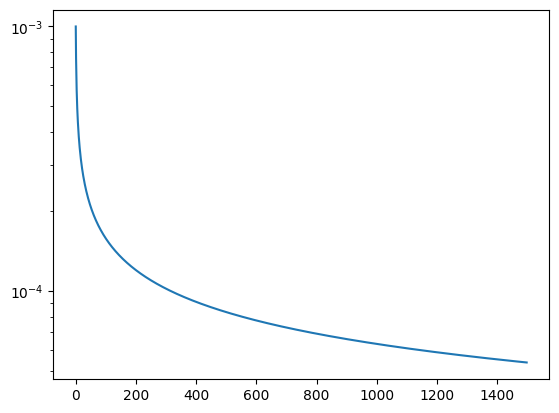

In [134]:
lr = [
    0.001 * i ** -0.4 for i in range(1, 1500)
]
plt.plot(range(len(lr)), lr)
plt.yscale('log')
plt.show()

In [129]:
lr[0], lr[-1]

(0.001, 5.366354354133977e-05)

In [140]:
import enum


class TRAFFIC_LIGHT_COLOR(str, enum.Enum):
    RED = "RED"
    GREEN = "GREEN"
    
    @classmethod
    def by_minute(cls, minutes: int) -> str:
        assert minutes >= 0, "Minutes must be a positive integer"
        assert minutes < 60, "Minutes must be less than 60"
        return cls.RED if minutes % 5 < 2 else cls.GREEN
    

In [147]:
TRAFFIC_LIGHT_COLOR.by_minute(0)
    

<TRAFFIC_LIGHT_COLOR.RED: 'RED'>

In [148]:
TRAFFIC_LIGHT_COLOR.by_minute(3)


<TRAFFIC_LIGHT_COLOR.GREEN: 'GREEN'>

In [149]:
TRAFFIC_LIGHT_COLOR.by_minute(400)


AssertionError: Minutes must be less than 60

In [144]:
TRAFFIC_LIGHT_COLOR.by_minute()


TypeError: TRAFFIC_LIGHT_COLOR.by_minute() missing 1 required positional argument: 'minutes'

In [145]:
def traffic_light_color(minutes: int) -> str:
    return "RED" if minutes % 5 < 2 else "GREEN"

In [146]:
traffic_light_color(0)


'RED'